In [1]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from data.prep import get_data_as_dataframe
from utils.data_utils import custom_train_test_split, calculate_mean_std

from plots import plot_acc_loss_curve

from models.vit import ViT

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from utils.train_utils import EarlyStopping
from engine import train, eval

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.3.1+cu121
Torchvision Version:  0.18.1+cu121


In [2]:
# ROOT path
ROOT = os.getcwd()

# Training mode
PRETRAINED = True

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# Data Preparation

In [3]:
# Path to datasets
DATA_PATH = os.path.join(ROOT, 'dataset')

# Dataset name
DATASET_NAME = 'SDNET2018'

df = get_data_as_dataframe(DATA_PATH, dataset_name=DATASET_NAME, balance=True)
df.head()

,image,label
0,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
1,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
2,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
3,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
4,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked


In [4]:
# define the train & test split
TEST_SIZE = 0.2

train_df, valid_df, test_df = custom_train_test_split(df, test_size=TEST_SIZE, stratify='label')

print(f"Train size: {train_df.shape}")
print(f"Validation size: {valid_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (4172, 2)
Validation size: (783, 2)
Test size: (261, 2)


In [5]:
print(f"Train data balance:\n {train_df.label.value_counts()}\n")
print(f"Validation data balance:\n {valid_df.label.value_counts()}\n")
print(f"Test data balance:\n {test_df.label.value_counts()}\n")

Train data balance:
 non-cracked    2086
cracked        2086
Name: label, dtype: int64

Validation data balance:
 non-cracked    392
cracked        391
Name: label, dtype: int64

Test data balance:
 cracked        131
non-cracked    130
Name: label, dtype: int64



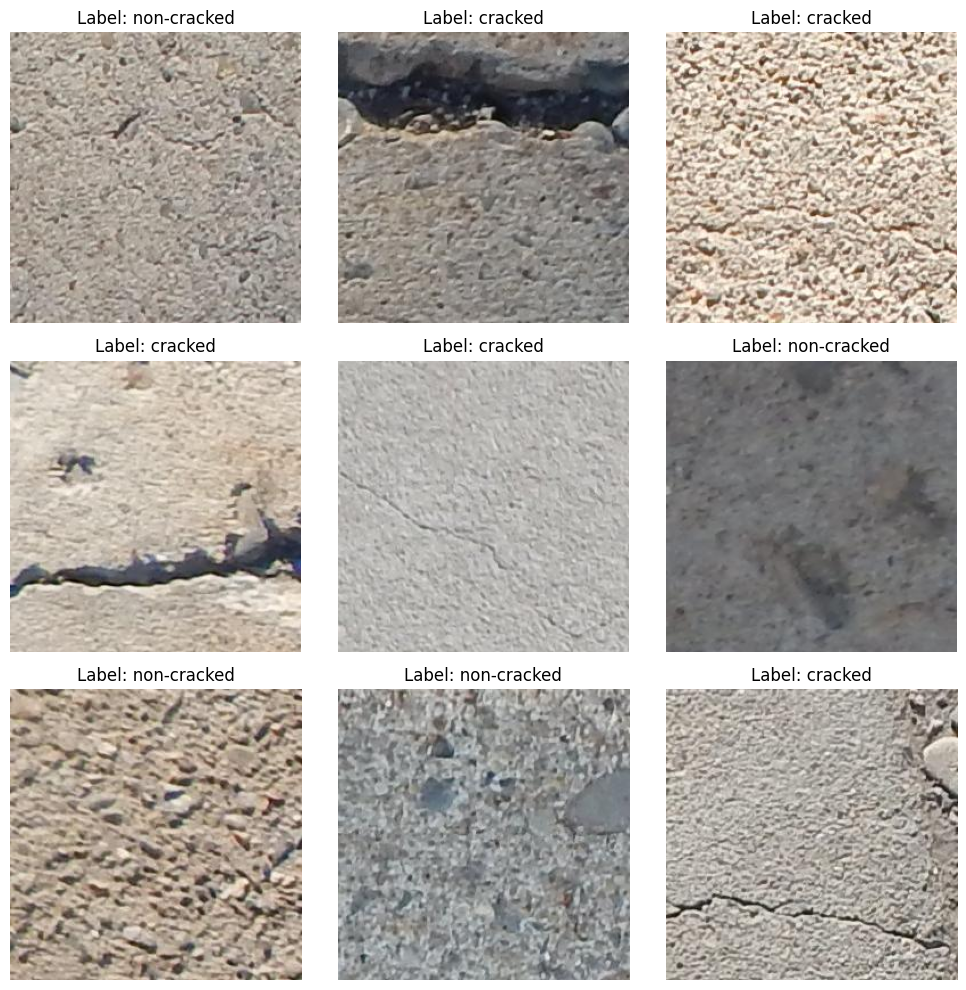

In [6]:
from plots import show_df

show_df(df=df, n_samples=9)

# Initialize Dataset and Dataloader for Training

In [7]:
class CrackDataset(Dataset):
    def __init__(self, df, dataset_name, transform=None):
        super().__init__()
        self.df_data = df.values
        self.dataset_name = dataset_name
        self.transform = transform

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        img_path, label = self.df_data[idx]
        image = Image.open(img_path).convert("RGB")
        label = 1 if label=='cracked' else 0

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [9]:
# define the input image dimensions
IMG_SIZE = 224

# define the batch size
BATCH_SIZE = 16

if PRETRAINED:
    MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) # ImageNet normalization
else:
    MEAN, STD = calculate_mean_std(train_df.copy())

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD), 
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
}

dataloaders = {
    'train': DataLoader(CrackDataset(train_df, DATASET_NAME, transform=data_transforms['train']), 
                        batch_size=BATCH_SIZE, shuffle=True, 
                        pin_memory=PIN_MEMORY),
    'valid': DataLoader(CrackDataset(valid_df, DATASET_NAME, transform=data_transforms['valid']), 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        pin_memory=PIN_MEMORY),
    'test': DataLoader(CrackDataset(test_df, DATASET_NAME, transform=data_transforms['valid']), 
                       batch_size=1, shuffle=False,
                       pin_memory=PIN_MEMORY)
}

Images batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: 16


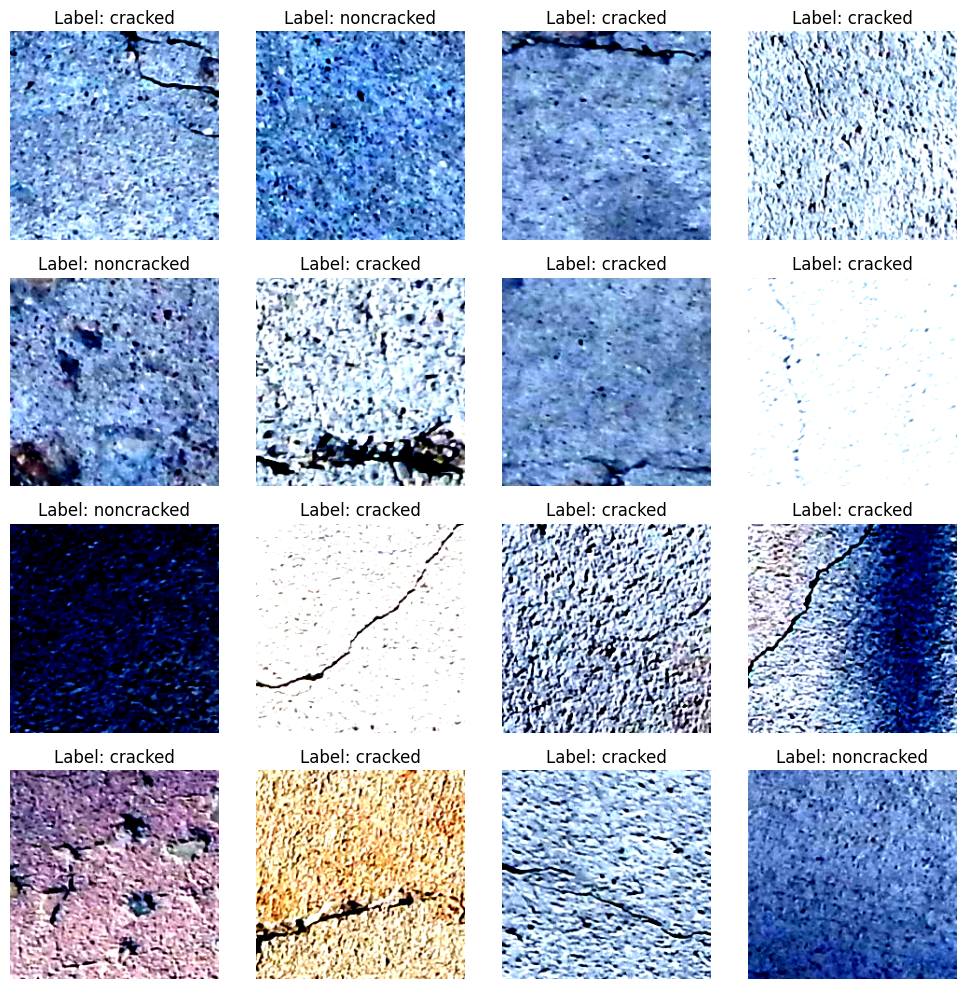

In [10]:
from plots import show_dl

show_dl(dataloaders['train'])

# ViT (Vision Transformer) Architecture

In [11]:
# num_classes = len(df.label.unique())
# model = ViT(size='base', patch_size=16, num_classes=num_classes, pretrained=PRETRAINED)

In [12]:
# model

In [13]:
# for layer, param in model.named_parameters():
#     if param.requires_grad:
#         print(layer)

# Fine-tune ViT

In [ ]:
# # initialize learning rate, number of epochs to train for, and the batch size
# INIT_LR = 1e-3
# MOMENTUM = 0.9

# # Send the model to GPU
# model = model.to(DEVICE)

# # Setup the loss function
# criterion = torch.nn.CrossEntropyLoss()

# # Model parameters where requires grad is True
# params_to_tune = [param for param in model.parameters() if param.requires_grad]

# # Observe that all parameters are being optimized
# optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM, weight_decay=1e-5)
# # optimizer = optim.Adam(params_to_tune, lr=INIT_LR, weight_decay=1e-5)

# # Update learning rate once validation loss stop decreasing
# scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience=5, threshold=1e-4)

# early_stopping = EarlyStopping(patience=5)

In [17]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning) 

# NUM_EPOCHS = 50

# train_hist = train(model, NUM_EPOCHS, dataloaders, DEVICE, criterion, optimizer, scheduler, early_stopping=early_stopping, multiple_gpu=True)

In [14]:
num_classes = len(df.label.unique())
model = ViT(size='base', patch_size=16, num_classes=num_classes, pretrained=PRETRAINED)
model = model.to(DEVICE)

# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 1e-2
MOMENTUM = 0.9

criterion = torch.nn.CrossEntropyLoss()

params_to_tune = [param for param in model.parameters() if param.requires_grad]

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM, weight_decay=1e-5)
# optimizer = optim.Adam(params_to_tune, lr=INIT_LR, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience=3, threshold=1e-4)

early_stopping = EarlyStopping(patience=3)

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

NUM_EPOCHS = 30

train_hist = train(model, NUM_EPOCHS, dataloaders, DEVICE, criterion, optimizer, scheduler, early_stopping=early_stopping, multiple_gpu=True)

Epoch [1/30] | Learning Rate: 0.01 | mem: 1027
	Train Loss: 0.3945 | Train Acc: 83.65%
	Val. Loss: 0.3449 | Val. Acc: 85.44%
Epoch [2/30] | Learning Rate: 0.01 | mem: 1027
	Train Loss: 0.3419 | Train Acc: 86.70%
	Val. Loss: 0.3644 | Val. Acc: 85.57%
Epoch [3/30] | Learning Rate: 0.01 | mem: 1027
	Train Loss: 0.3503 | Train Acc: 87.15%
	Val. Loss: 0.2902 | Val. Acc: 88.12%
Epoch [4/30] | Learning Rate: 0.01 | mem: 1027
	Train Loss: 0.3438 | Train Acc: 87.56%
	Val. Loss: 0.3684 | Val. Acc: 85.82%
Epoch [5/30] | Learning Rate: 0.01 | mem: 1027
	Train Loss: 0.2808 | Train Acc: 88.97%
	Val. Loss: 0.3856 | Val. Acc: 86.33%
Epoch [6/30] | Learning Rate: 0.01 | mem: 1027
	Train Loss: 0.2880 | Train Acc: 89.14%
	Val. Loss: 0.3437 | Val. Acc: 86.85%
Epoch [7/30] | Learning Rate: 0.008 | mem: 1027
	Train Loss: 0.2634 | Train Acc: 90.12%
	Val. Loss: 0.3166 | Val. Acc: 87.61%
Epoch [8/30] | Learning Rate: 0.008 | mem: 1027
	Train Loss: 0.2589 | Train Acc: 89.88%
	Val. Loss: 0.3079 | Val. Acc: 87.23

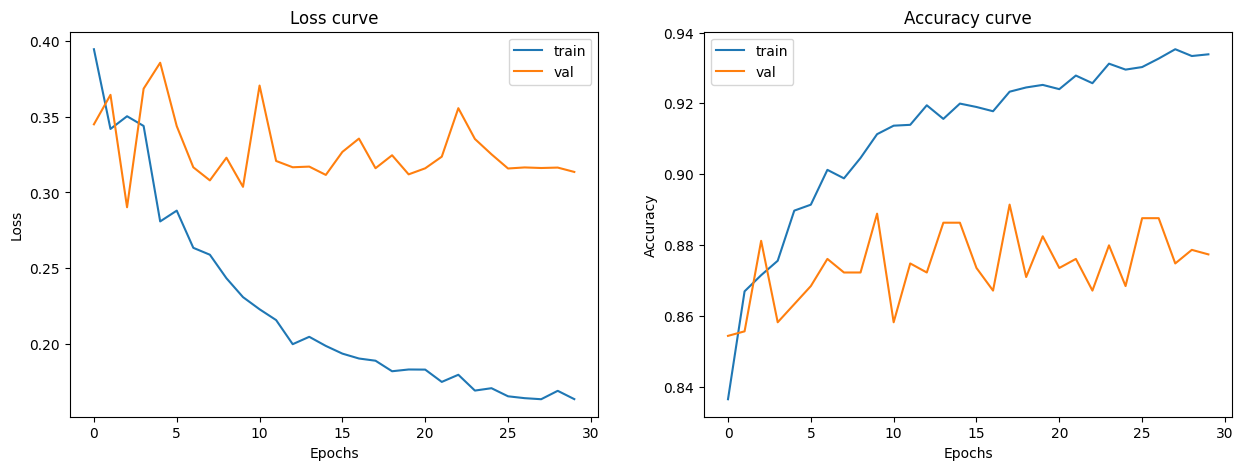

In [15]:
plot_acc_loss_curve(train_hist)

# Evaluation

In [ ]:
for i in ['train', 'valid', 'test']: 
    model.eval()

    batch_loss = 0.0
    batch_corrects = 0
    # Iterate over the batches of the validation loader
    with torch.no_grad():
        for inputs, labels in dataloaders[i]:
            # Move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Update the running loss and accuracy
            batch_loss += loss.item() * inputs.size(0)
            batch_corrects += torch.sum(preds == labels.data)

    test_dataset_len = dataloaders[i].dataset.__len__()
    test_loss = batch_loss / test_dataset_len
    test_acc = batch_corrects.double() / test_dataset_len

    print(f"{i} loss: {test_loss}, {i} acc: {test_acc}")

train loss: 0.11498150340534125, train acc: 0.9621284755512943
valid loss: 0.8901628206363887, valid acc: 0.7407407407407408
test loss: 0.9911246280688153, test acc: 0.7011494252873562
